# Project 2

In [69]:
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import zscore
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import shap
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.nn.functional as F

import nam.utils.graphing as graphing
importlib.reload(graphing)

from nam.wrapper import NAMClassifier

## Part 1, Heart Disease Prediction Dataset (20 Pts)

#### Q1: Exploratory Data Analysis (3 Pts) 

Exploring and cleaning the data is inspired by:
https://www.kaggle.com/code/durgancegaur/a-guide-to-any-classification-problem

In [5]:
train_data_path = "heart_failure/train_val_split.csv"
test_data_path = "heart_failure/test_split.csv"

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [6]:
print("TRAIN DATA:")
print(f"Sample size: {len(train_data)}")
print(f"shape: {train_data.shape}")

print()

print("TEST DATA:")
print(f"Sample size: {len(test_data)}")
print(f"Shape: {test_data.shape}")

TRAIN DATA:
Sample size: 734
shape: (734, 12)

TEST DATA:
Sample size: 184
Shape: (184, 12)


The following is also from:
https://www.kaggle.com/code/durgancegaur/a-guide-to-any-classification-problem

##### The Attributess include:
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

In [7]:
print("TRAIN DATA:")
train_data.head()

TRAIN DATA:


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0


In [8]:
# FIXME: Porbably not needed
# Convert entries with type object to type string
string_col = train_data.select_dtypes(include="object").columns
train_data[string_col]=train_data[string_col].astype("string")

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734 entries, 0 to 733
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             734 non-null    int64  
 1   Sex             734 non-null    string 
 2   ChestPainType   734 non-null    string 
 3   RestingBP       734 non-null    int64  
 4   Cholesterol     734 non-null    int64  
 5   FastingBS       734 non-null    int64  
 6   RestingECG      734 non-null    string 
 7   MaxHR           734 non-null    int64  
 8   ExerciseAngina  734 non-null    string 
 9   Oldpeak         734 non-null    float64
 10  ST_Slope        734 non-null    string 
 11  HeartDisease    734 non-null    int64  
dtypes: float64(1), int64(6), string(5)
memory usage: 68.9 KB


In [9]:
# Check if there are any Nan vlaues
train_data.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [10]:
train_data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,734.000000,734.00000,734.000000,734.000000,734.000000,734.000000,734.000000
mean,53.523161,132.06267,197.588556,0.232970,136.167575,0.873978,0.542234
std,9.421110,18.61849,108.979439,0.423012,25.334552,1.082222,0.498553
min,29.000000,0.00000,0.000000,0.000000,60.000000,-2.000000,0.000000
25%,47.000000,120.00000,172.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.00000,222.000000,0.000000,138.000000,0.500000,1.000000
75%,60.000000,140.00000,267.000000,0.000000,155.000000,1.500000,1.000000
max,77.000000,200.00000,529.000000,1.000000,195.000000,6.200000,1.000000


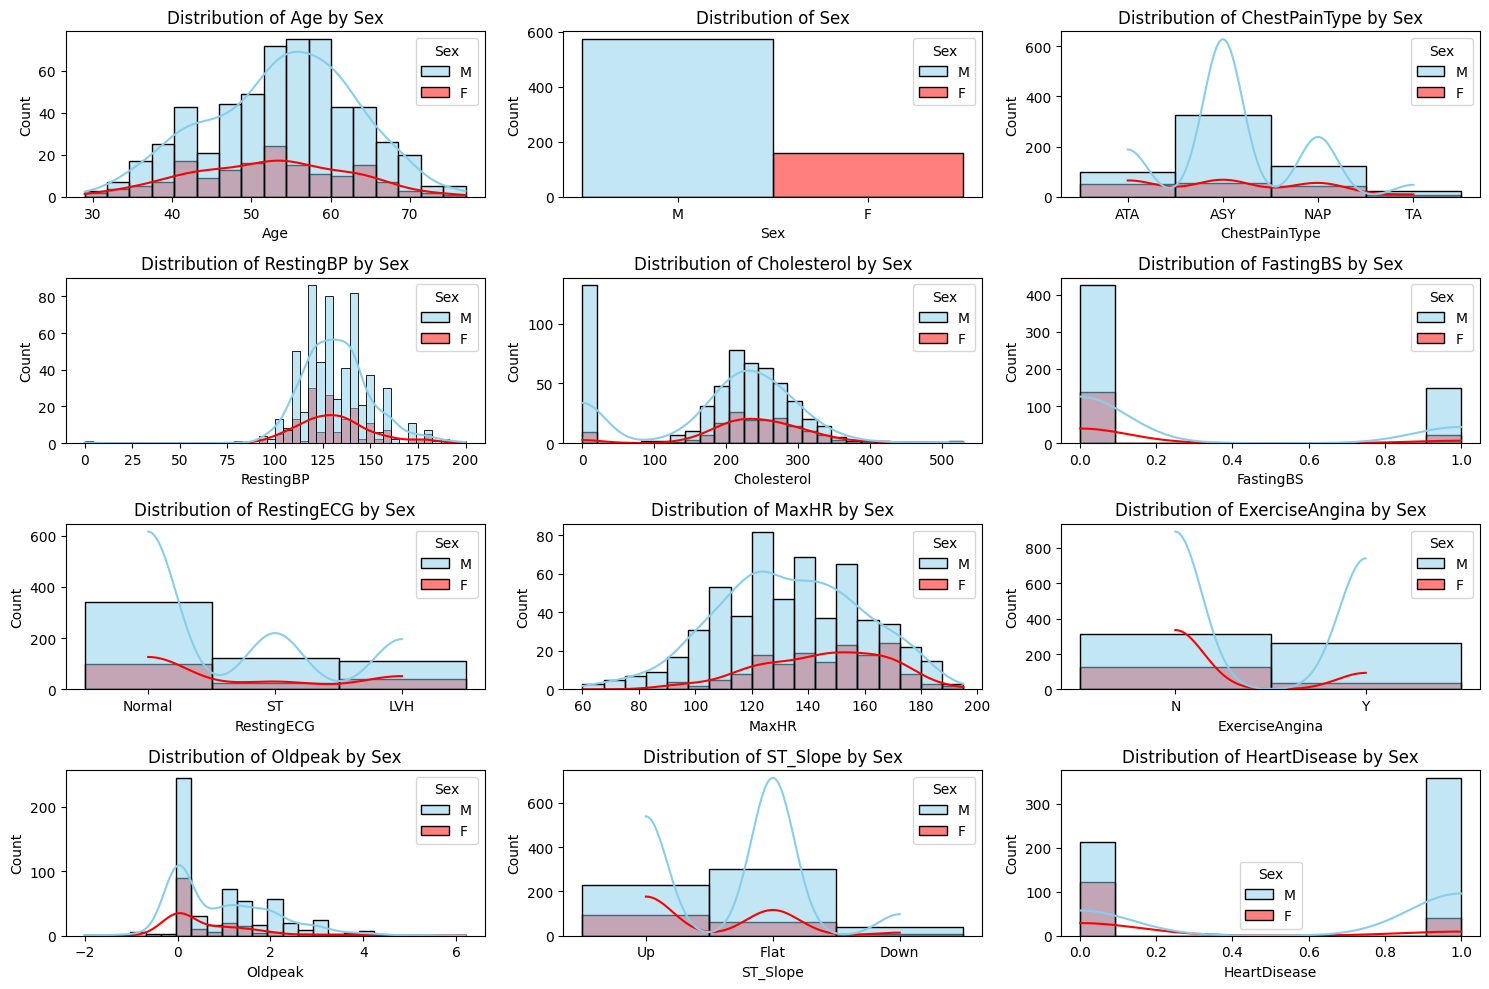

In [11]:
plt.figure(figsize=(15,10))
# for i,col in enumerate(train_data.columns,1):
#     plt.subplot(4,3,i)
#     plt.title(f"Distribution of {col} Data")
#     sns.histplot(train_data[col],kde=True)
#     plt.tight_layout()
#     plt.plot()

for i, col in enumerate(train_data.columns, 1):
    if col != "Sex":
        plt.subplot(4, 3, i)
        plt.title(f"Distribution of {col} by Sex")
        sns.histplot(data=train_data, x=col, hue="Sex", kde=True, palette={"M": "skyblue", "F": "red"})
        plt.tight_layout()
    elif col == "Sex":
        plt.subplot(4, 3, i)
        plt.title(f"Distribution of Sex")
        sns.histplot(data=train_data, x=col, hue="Sex", kde=True, palette={"M": "skyblue", "F": "red"})
        plt.tight_layout()

    plt.plot()
        

Unusual feature distribution (Not finished yet)
- Age is pretty much distributed normally
- There are way more male than female
- Majority of pain is asymptomatic chest pain
- Median resting BP is around 130mmHg, which is slightly higher than a healthy resting BP, which is usually below 120mmHg
- The cholesterol level cannot be zero, which means there are some wrong values in the training data set

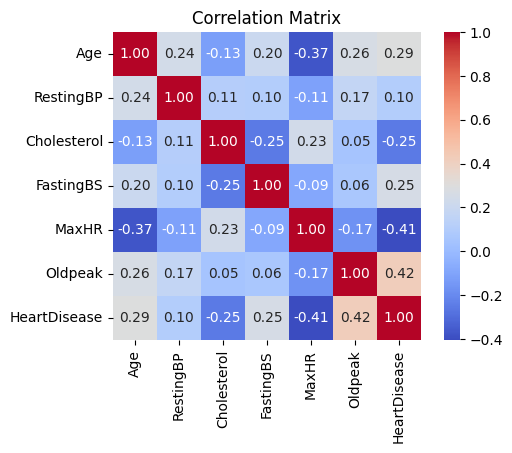

In [12]:
# Categorical features
catecorical_features = train_data.select_dtypes("string").columns.to_list()
numerical_features = train_data.columns.to_list()

for col in catecorical_features:
    numerical_features.remove(col)
# numerical_features.remove("HeartDisease")

# Checking for correlation between the numerical features
correlation_matrix = train_data[numerical_features].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()

In [13]:
# Checking for missing values
missing_values = train_data.isnull().sum()
print(f"Missing values in the dataset:\n{missing_values}")

Missing values in the dataset:
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [14]:
# According to https://developers.google.com/machine-learning/crash-course/overfitting/imbalanced-datasets,
# if the minority class has 20-40% of the dataset then the imbalance is mild. If it has 1-20%
# then the imbalance is moderate. If the minority class has <1% of the dataset then it is a extremely imbalanced.

# We can see from below that our training data set is pretty balanced, and we don't need to balanced it.

In [15]:
label_ratio = train_data['HeartDisease'].value_counts(normalize=True)
print("Label Ratio in Train Data:")
print(label_ratio)

Label Ratio in Train Data:
HeartDisease
1    0.542234
0    0.457766
Name: proportion, dtype: float64


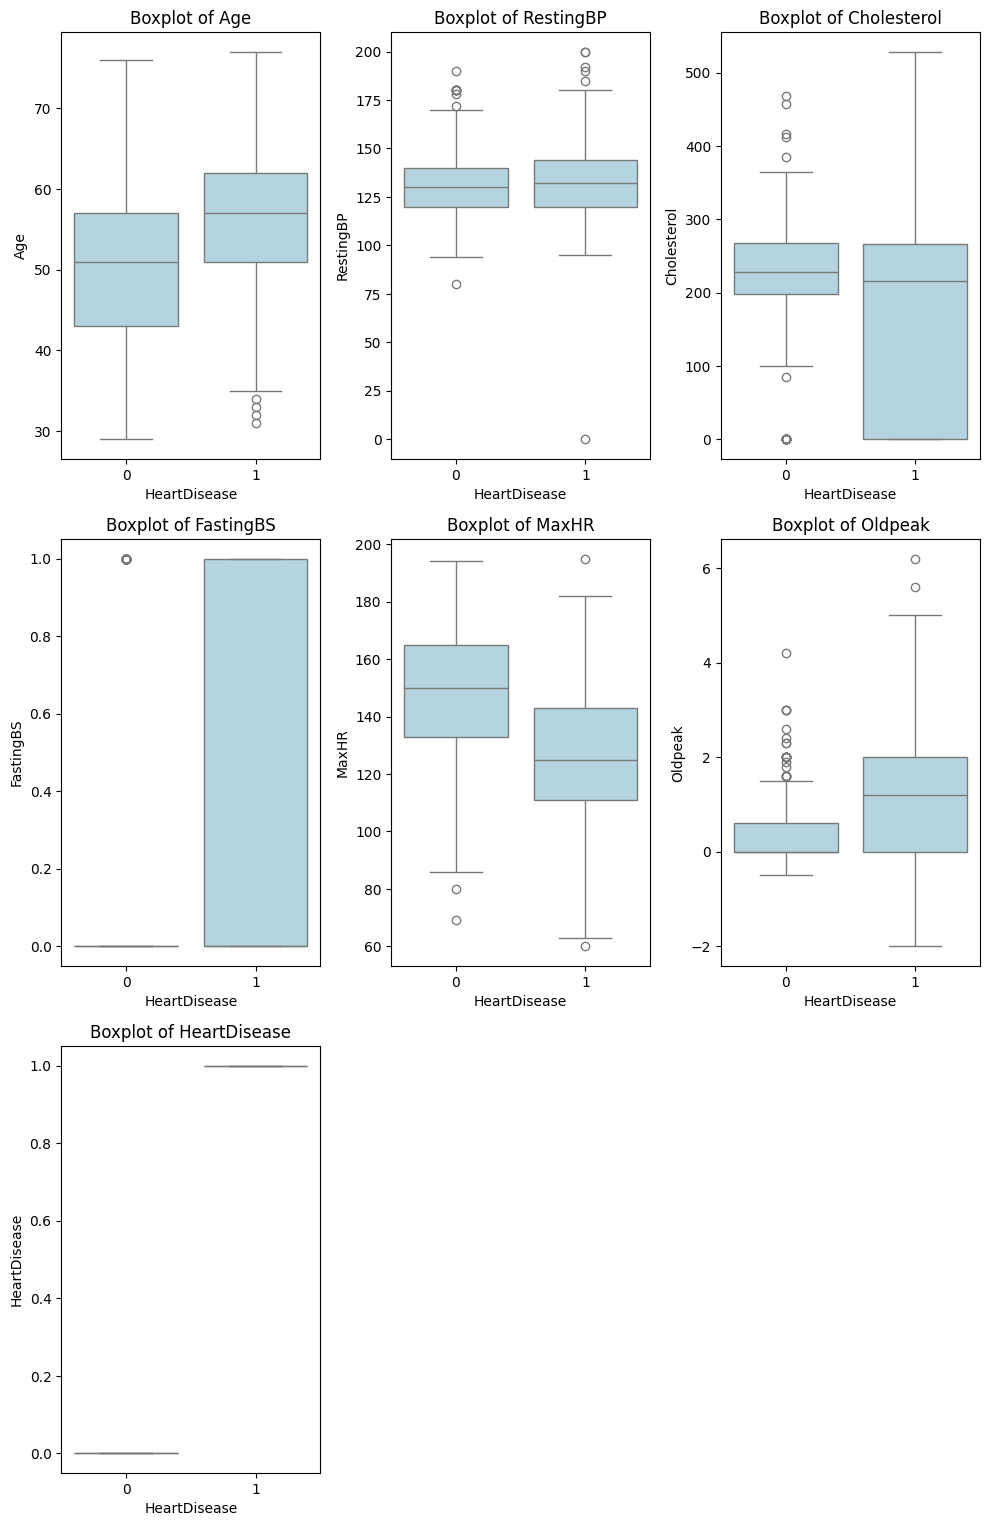

In [16]:
# Check for outliers with boxplot for each numerical feature
# numerical_features.remove("HeartDisease")
# numerical_features.remove("FastingBS")
plt.figure(figsize=(10, 20))  # Adjusted figure size for narrower and taller plots
for i, col in enumerate(numerical_features, 1):
    plt.subplot(4, 3, i)
    plt.title(f"Boxplot of {col}")
    sns.boxplot(data=train_data, y=col,x="HeartDisease",color="lightblue")
    plt.tight_layout()

Describe how to handel the above mentioned pitfalls (TODO)

In [17]:
# Preprocess the data
# 1. Removing Outliers from numerical features
# 2. Handling Null values (none in our case)
# 3. Handlig Categorical Variables
# 4. Feature Scaling

In [18]:
# Outlier removal with Interquartile range (IQR) method
# FIXME: Don't remove outliers but rather cap them
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

def remove_outliers_iqr(df, columns):
    cleaned_df = df.copy()
    for col in columns:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)]
    return cleaned_df

df_cleaned_with_iqr = remove_outliers_iqr(train_data, numerical_cols)

df_cleaned_with_iqr.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,463.000000,463.000000,463.000000,463.0,463.000000,463.000000,463.000000
mean,51.699784,129.555076,239.200864,0.0,140.887689,0.777322,0.410367
std,9.661284,15.088365,50.665363,0.0,23.756528,0.967471,0.492432
min,29.000000,94.000000,85.000000,0.0,80.000000,-0.100000,0.000000
25%,44.000000,120.000000,205.500000,0.0,123.500000,0.000000,0.000000
50%,52.000000,130.000000,234.000000,0.0,142.000000,0.200000,0.000000
75%,58.000000,140.000000,271.000000,0.0,160.000000,1.500000,1.000000
max,77.000000,170.000000,404.000000,0.0,192.000000,3.600000,1.000000


In [19]:
# Outlier removal with Z-score method
# Copy of the data
df_zscore = train_data.copy()

# List of numerical features
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']

# Compute Z-scores
z_scores = np.abs(zscore(df_zscore[numerical_cols]))

# Choose a threshold for outliers (commonly 3.0)
threshold = 3.0

# Create a boolean mask where all z-scores are below threshold
mask = (z_scores < threshold).all(axis=1)

# Apply mask to keep only non-outlier rows
df_cleaned_with_zscore = df_zscore[mask]

df_cleaned_with_zscore.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,720.000000,720.000000,720.000000,720.000000,720.00000,720.000000,720.000000
mean,53.530556,131.711111,197.088889,0.233333,136.31250,0.839444,0.536111
std,9.443141,17.226298,108.219606,0.423247,25.13631,1.014567,0.499041
min,29.000000,80.000000,0.000000,0.000000,63.00000,-2.000000,0.000000
25%,47.000000,120.000000,172.750000,0.000000,120.00000,0.000000,0.000000
50%,54.000000,130.000000,221.500000,0.000000,138.00000,0.500000,1.000000
75%,60.000000,140.000000,266.250000,0.000000,155.00000,1.500000,1.000000
max,77.000000,185.000000,518.000000,1.000000,194.00000,4.000000,1.000000


In [20]:
# Encoding categorical features using one-hot encoding
# FIXME: Maybe use different preprocessed data. Currently df_cleaned_with_zscore gives the best result
catecorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
train_data_encoded = pd.get_dummies(df_cleaned_with_zscore, columns=catecorical_features, drop_first=True)
test_data_encoded = pd.get_dummies(test_data, columns=catecorical_features, drop_first=True)


Q2.1: Fit a Lasso regression model with L1 regularization on the dataset (1 Pt)

In [21]:
# Split features and target
X_train = train_data_encoded.drop(columns=['HeartDisease'], axis=1)
y_train = train_data_encoded['HeartDisease']

X_test = test_data_encoded.drop(columns=['HeartDisease'], axis=1)
y_test = test_data_encoded['HeartDisease']

# Standardize features
scaler = MinMaxScaler()
# sclaer = RobustScaler()
# scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
# Fit Lasso Logistic Regression
model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
model.fit(X_train_scaled, y_train)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

Q2.2: Provide performance metrics such as f1-score or balanced accuracy (1 Pt)

In [23]:
# Predict on the test set
y_pred = model.predict(X_test_scaled)

# Compute performance metrics
f1 = f1_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)

# Print the results
print(f"F1 Score:  {f1:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")

F1 Score:  0.8811
Balanced Accuracy: 0.8397


Q2.4: Visualize the importance of the different features and argue how they contribute to the 
model's output (1 Pt) 

In [24]:
# Get feature names
feature_names = X_train.columns

# Get coefficients from the trained model
coefficients = model.coef_[0]

# Combine feature names with coefficients
feature_importance = pd.Series(coefficients, index=feature_names)

# Display selected features and their weights
print("Selected Features with Non-zero Coefficients:")
print(feature_importance.sort_values(key=abs, ascending=False))


Selected Features with Non-zero Coefficients:
Cholesterol         -2.036102
ChestPainType_ATA   -2.019115
Oldpeak              1.835314
ChestPainType_NAP   -1.605607
Sex_M                1.411806
ST_Slope_Up         -1.332796
ST_Slope_Flat        1.047535
ExerciseAngina_Y     0.947260
FastingBS            0.844794
Age                  0.762409
ChestPainType_TA    -0.731264
MaxHR               -0.598196
RestingECG_ST       -0.144232
RestingECG_Normal   -0.046521
RestingBP            0.000000
dtype: float64


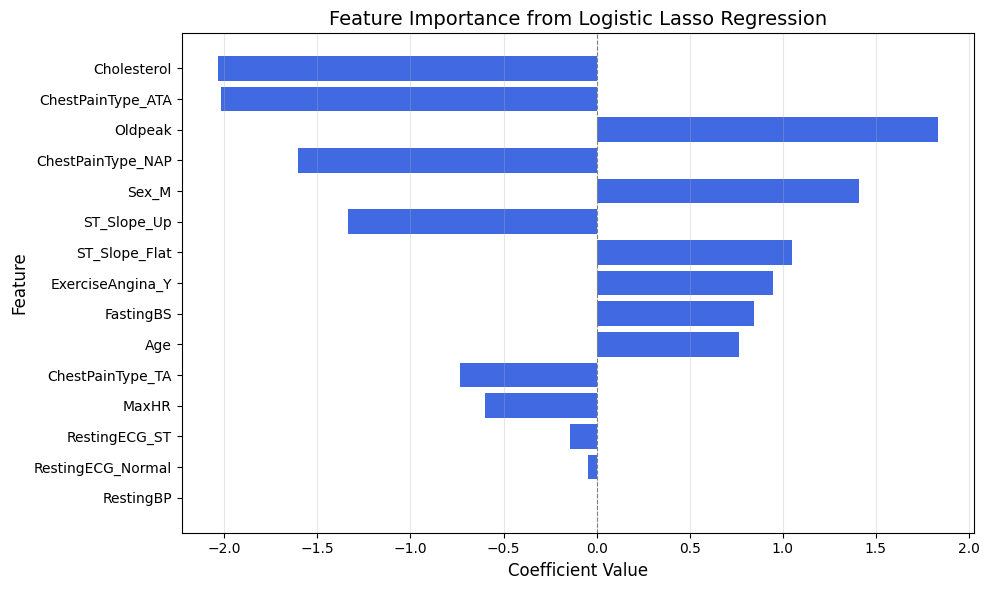

In [25]:
# Create a DataFrame for easier plotting
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df = coef_df.sort_values('Coefficient', key=abs, ascending=False)

# Create the plot
plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='royalblue')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=0.8)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance from Logistic Lasso Regression', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.gca().invert_yaxis()  # Show highest coefficients at top

plt.tight_layout()
plt.show()

Q3.1: Similar to Q2, implement a simple MLP, train it on the dataset, and report test set performanbce (2 Pt)

In [26]:
# Initialize MLP model
mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # Two hidden layers
    activation='relu',           # Rectified Linear Unit activation
    solver='adam',               # Adaptive moment estimation optimizer
    alpha=0.001,                # L2 regularization strength
    batch_size=32,              # Mini-batch size
    learning_rate_init=0.001,   # Initial learning rate
    max_iter=200,               # Maximum number of iterations
    random_state=42,            # For reproducibility
    early_stopping=True,        # Stop training if validation score doesn't improve
    validation_fraction=0.1     # Fraction of training data for validation
)

# Train the model
mlp_model.fit(X_train_scaled, y_train)

MLPClassifier(alpha=0.001, batch_size=32, early_stopping=True,
              hidden_layer_sizes=(64, 32), random_state=42)

In [27]:
# Evaluate on test set
y_pred = mlp_model.predict(X_test_scaled)
y_proba = mlp_model.predict_proba(X_test_scaled)[:, 1]  # Probability estimates for class 1

# Performance metrics
f1 = f1_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)

print(f"F1 Score: {f1:.3f}")
print(f"Balanced Accuracy: {bal_acc:.3f}")

F1 Score: 0.872
Balanced Accuracy: 0.828


In [28]:
# Since MLPs can be slow for SHAP, we use a subset of data
background = X_train_scaled[:100]  # Reference background (e.g., k-means samples)
test_samples = X_train_scaled   # Samples to explain

# Initialize SHAP explainer
explainer = shap.KernelExplainer(mlp_model.predict_proba, background)
shap_values = explainer.shap_values(test_samples)

# Get predicted probabilities
pred_probs = mlp_model.predict_proba(test_samples)

100%|██████████| 720/720 [03:07<00:00,  3.85it/s]


Q3.2: Visualize SHAP explanations of the outputs of two positive and negative samples 
and feature importances of the overall model (2 Pt)

In [29]:
explainer = shap.Explainer(mlp_model.predict, X_train_scaled, feature_names=feature_names)
shap_values = explainer(X_train_scaled)

# get indices of the first 2 positive and 2 negative samples
index_negatives = y_train[y_train == 0].index[:2]
index_positives = y_train[y_train == 1].index[:2]


PermutationExplainer explainer: 721it [01:32,  7.80it/s]                         


Negative Sample 0:


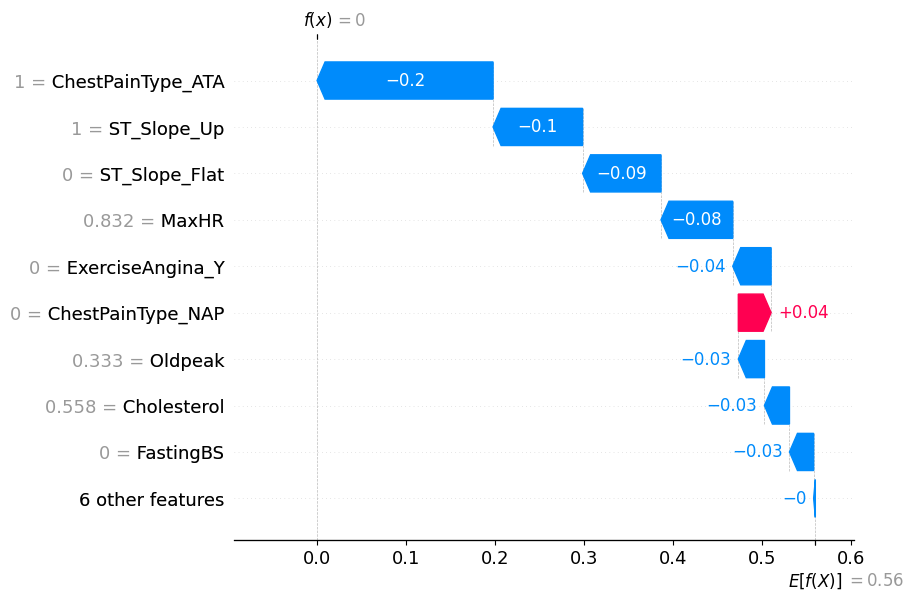

Negative Sample 1:


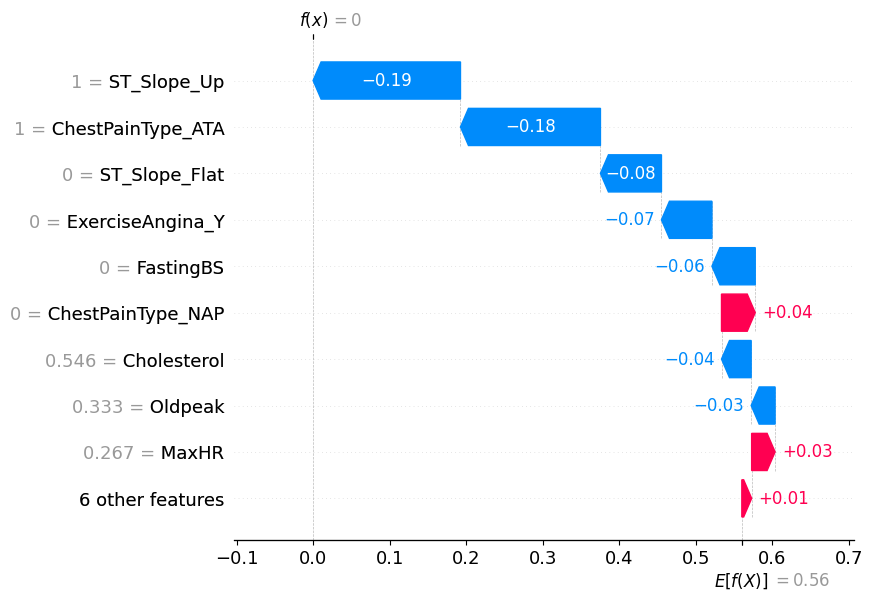

Positive Sample 2:


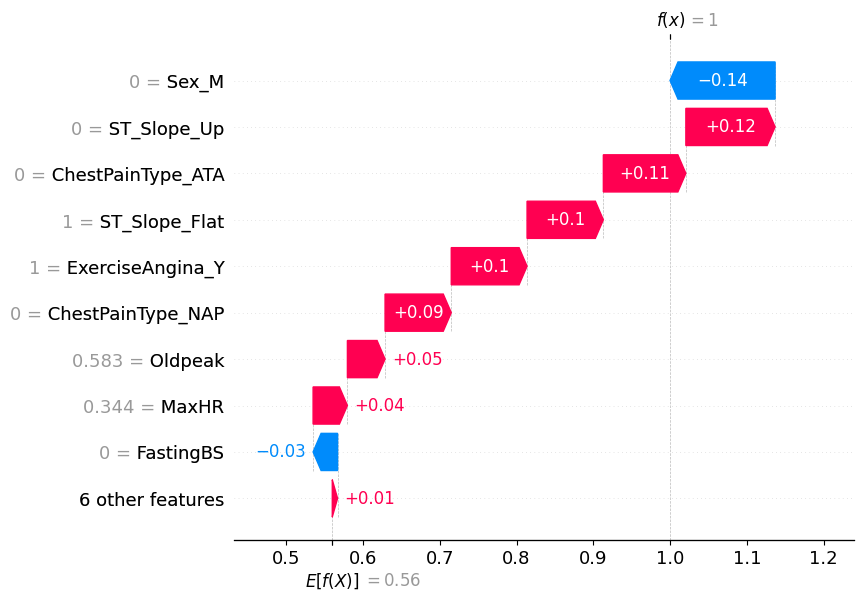

Positive Sample 7:


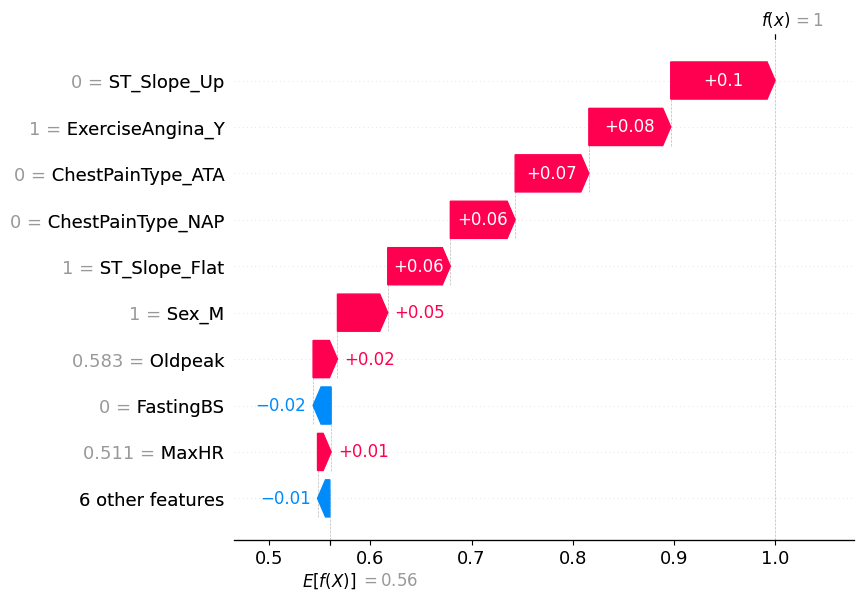

In [30]:
for i in index_negatives:
    print(f"Negative Sample {i}:")
    shap.plots.waterfall(shap_values[i], max_display=10)
    plt.show()

for i in index_positives:
    print(f"Positive Sample {i}:")
    shap.plots.waterfall(shap_values[i], max_display=10)
    plt.show()


C:\Users\rahul\AppData\Local\Temp\ipykernel_17192\3884344605.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train_scaled, plot_type="bar")


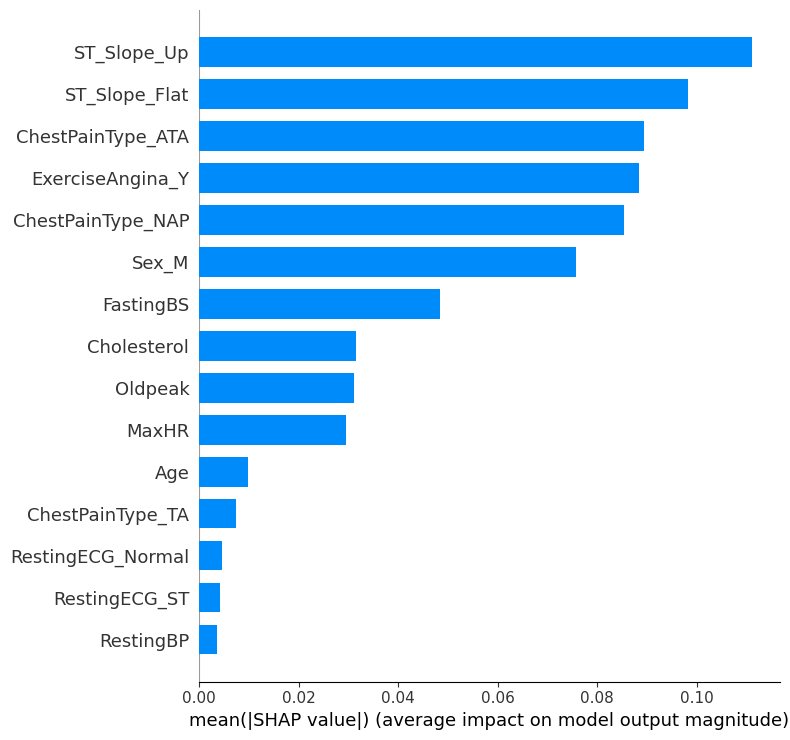

In [31]:
# show shap values for all samples
shap.summary_plot(shap_values, X_train_scaled, plot_type="bar")

Q4.1: Read the paper about NAMs, implement the model, train it on the dataset (Q3 Pt).

The model architecture was inspired by:
https://colab.research.google.com/drive/1E3_t7Inhol-qVPmFNq1Otj9sWt1vU_DQ?usp=sharing#scrollTo=dO8uWD63SQwI

And the code was partially used from:
https://github.com/lemeln/nam/tree/main and
https://github.com/AmrMKayid/nam/blob/main/tutorial.ipynb

In [32]:
import sklearn.metrics as sk_metrics

nam_model = NAMClassifier(
            num_epochs=10,
            num_learners=20,
            metric='auroc',
            early_stop_mode='max',
            monitor_loss=False,
            n_jobs=10,
            random_state=42
        )

nam_model.fit(X_train_scaled, y_train)

In [33]:
# Evaluate the model
pred = nam_model.predict_proba(X_test_scaled)
pred = np.where(pred >= 0.5, 1, 0)

f1 = f1_score(y_test, pred)
balanced_acc = balanced_accuracy_score(y_test, pred)
print(f"F1 Score: {f1:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")

F1 Score: 0.8621
Balanced Accuracy: 0.8059


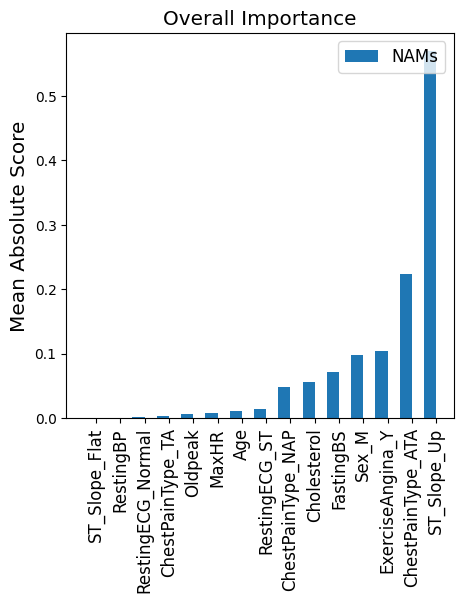

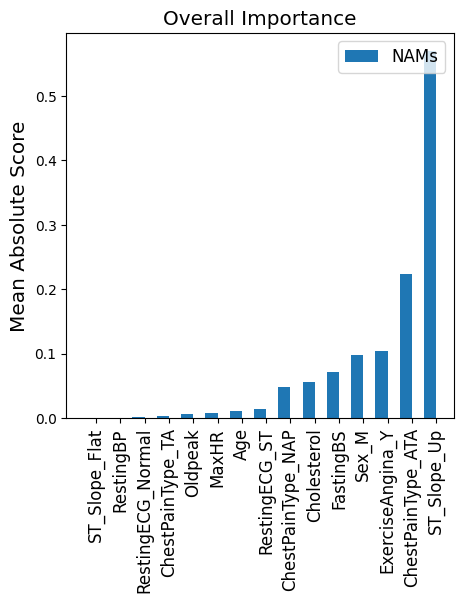

In [71]:
custom_features = scaler.feature_names_in_
graphing.plot_mean_feature_importance(nam_model, X_train_scaled, custom_features)